# AEGAN datasets benchmark

In [67]:
import pandas as pd
import os 
import sys
sys.path.append('/disk1/ariane/vscode/enzyme-tk/')
from enzymetk.sequence_search_blast import BLAST
from enzymetk.save_step import Save
from sciutil import SciUtil 

u = SciUtil()

# Basically want to run blast on each of the datasets and see how many get the correct active site
# We do this filtering first to remove them from the sequence set
data_dir = '/disk1/ariane/vscode/squidly/aegan_structures/AEGAN_extracted_sequences/'
files = os.listdir(data_dir)
swissprot = pd.read_csv('data/wills_metadata.tsv', sep='\t')
swissprot = pd.read_csv('../enzyme_datasets_benchmark/swissprot.tsv', sep='\t')
swissprot = pd.read_csv('data/reviewed_sprot_08042025.tsv', sep='\t')

def annotate_residue_from_uniprot(df):
    # Organise the active sites of these guys to be better
    active_sites = []
    active_site_residue_counts = []
    x = 0
    for act_site in df['Active site'].values:
        sites = []
        if isinstance(act_site, str):
            act_site = act_site.replace(" ", '')
            for act in act_site.split('ACT_SITE'):
                try:
                    sites.append(int(act.split(';')[0].replace(" ", '')) - 1) # Need to subtract 1 to make it fit with the fact that python is 0 encoded lol
                except:
                    x = 1
        if len(sites) != 0:
            active_sites.append('|'.join([str(s) for s in sites]))
            active_site_residue_counts.append(len(sites))
        else:
            active_sites.append('None')
            active_site_residue_counts.append(0)
    df['Residue'] = active_sites
    df['active_site_residue_counts'] = active_site_residue_counts
    return df
    
swissprot = annotate_residue_from_uniprot(swissprot)
swissprot = swissprot[swissprot['active_site_residue_counts'] > 0]
training_ids = set(pd.read_csv('data/AEGAN_real_training_set.txt', header=None)[0].values)
training_df = swissprot[swissprot['Entry'].isin(training_ids)]

u.dp(['Number of AEGAN training set:', len(training_df)])

--------------------------------------------------------------------------------
                      Number of AEGAN training set:	9888	                       
--------------------------------------------------------------------------------


In [31]:
training_df[training_df['Residue'] == 'None']

,Entry,Length,Sequence,Active site,PDB,Residue,active_site_residue_counts


In [53]:

import sys
sys.path.append('/disk1/ariane/vscode/enzyme-tk/')
from enzymetk.predict_catalyticsite_step import ActiveSitePred

squidly_dir = '/disk1/ariane/vscode/enzyme-tk/models/squidly_final_models/'

for f in files:
    try:
        df = pd.read_csv(f'{data_dir}{f}/{f}.tsv', sep='\t')
        entries = set(list(df['Entry'].values))
        # Remove from SwissProt
        # Now we're going to save this as a fasta file 
        fasta_label = f'data/AEGAN/AEGAN_with_active_site_seqs_{f}.fasta'
        with open(fasta_label, 'w+') as fout:
            for entry, seq in training_df[['Entry', 'Sequence']].values:
                if entry not in entries:
                    fout.write(f'>{entry}\n{seq}\n')
        # Do blast on this dataset 
        # This should be where you downloaded the data from zotero, there is a folder in there called AS_inference
        # This contains the models and the data needed to run the tool
        id_col = 'Entry'
        seq_col = 'Sequence'
        squidly = (df << (ActiveSitePred(id_col, seq_col, squidly_dir, esm2_model = 'esm2_t36_3B_UR50D') >> Save(f'data/squidly/{f}_squidly_as_pred_3B.pkl')))
    except:
        print(f)

EF_family_BLAST.csv
NN_BLAST.pkl
HA_superfamily_BLAST.pkl
PC_BLAST.csv
EF_fold_BLAST.csv
PC_BLAST.pkl
HA_superfamily_BLAST.csv
EF_fold_BLAST.pkl
NN_BLAST.csv
EF_superfamily_BLAST.pkl
EF_superfamily_BLAST.csv
EF_family
EF_family_BLAST.pkl


In [68]:
from enzymetk.predict_catalyticsite_step import ActiveSitePred

import sys
sys.path.append('/disk1/ariane/vscode/enzyme-tk/')
squidly_dir = '/disk1/ariane/vscode/enzyme-tk/models/squidly_final_models/'

for f in files:
    try:
        if f == 'PC':
            print('Starting')
            df = pd.read_csv(f'{data_dir}{f}/{f}.tsv', sep='\t')
            entries = set(list(df['Entry'].values))
            # Remove from SwissProt
            # Now we're going to save this as a fasta file 
            fasta_label = f'data/AEGAN/AEGAN_with_active_site_seqs_{f}.fasta'
            with open(fasta_label, 'w+') as fout:
                for entry, seq in training_df[['Entry', 'Sequence']].values:
                    if entry not in entries:
                        fout.write(f'>{entry}\n{seq}\n')
            # Do blast on this dataset 
            # This should be where you downloaded the data from zotero, there is a folder in there called AS_inference
            # This contains the models and the data needed to run the tool
            id_col = 'Entry'
            seq_col = 'Sequence'
            print('GOING')
            squidly = (df << (ActiveSitePred(id_col, seq_col, squidly_dir, esm2_model = 'esm2_t48_15B_UR50D') >> Save(f'data/Squidly/{f}_squidly_as_pred_15B.pkl')))
    except:
        print(f)

Starting
GOING


# Now for each test set we want to look for the closest sequence in the AEGAN training set 

We do this for each of the sequneces in AEGAN.

In [7]:
%%capture

for f in files:
    try:
        df = pd.read_csv(f'{data_dir}{f}/{f}.tsv', sep='\t')
        entries = set(list(df['Entry'].values))
        # Remove from SwissProt
        # Now we're going to save this as a fasta file 
        fasta_label = f'data/AEGAN/AEGAN_with_active_site_seqs_{f}.fasta'
        with open(fasta_label, 'w+') as fout:
            for entry, seq in training_df[['Entry', 'Sequence']].values:
                if entry not in entries:
                    fout.write(f'>{entry}\n{seq}\n')
        # Do blast on this dataset 
        # This should be where you downloaded the data from zotero, there is a folder in there called AS_inference
        # This contains the models and the data needed to run the tool
        id_col = 'Entry'
        seq_col = 'Sequence'
        df << (BLAST(id_col, seq_col, database=fasta_label, args=['--ultra-sensitive']) >> Save(f'data/AEGAN/blast/{f}_BLAST.pkl'))
    except:
        print(f)
        # Use this to suppress the output of the cell... 

diamond v2.1.11.165 (C) Max Planck Society for the Advancement of Science, Benjamin Buchfink, University of Tuebingen
Documentation, support and updates available at http://www.diamondsearch.org
Please cite: http://dx.doi.org/10.1038/s41592-021-01101-x Nature Methods (2021)

#CPU threads: 384
Scoring parameters: (Matrix=BLOSUM62 Lambda=0.267 K=0.041 Penalties=11/1)
Database input file: data/AEGAN/AEGAN_with_active_site_seqs_PC.fasta
Opening the database file...  [0.002s]
Loading sequences...  [0.016s]
Masking sequences...  [0.029s]
Writing sequences...  [0.002s]
Hashing sequences...  [0.001s]
Loading sequences...  [0s]
Writing trailer...  [0.008s]
Closing the input file...  [0s]
Closing the database file...  [0s]

Database sequences  9870
  Database letters  4032426
     Database hash  129885c69cb938b471437545d84ffcb5
        Total time  0.060000s
diamond v2.1.11.165 (C) Max Planck Society for the Advancement of Science, Benjamin Buchfink, University of Tuebingen
Documentation, support

# For each of these now what we want to do is to pull out the familiies and align using the clustal omega 

In [33]:
files = os.listdir('data/AEGAN/blast/')
results = {}
for f in files:
    try:
        label = f.split('_BLAST.pkl')[0]
        df = pd.read_csv(f'{data_dir}{label}/{label}.tsv', sep='\t')
        entries = set(list(df['Entry'].values))
        blast_df = pd.read_pickle(f'data/AEGAN/blast/{f}')
        blast_df = blast_df.sort_values(by='sequence identity', ascending=False)
        blast_df.drop_duplicates('query', inplace=True)
        # Then join up with all df
        blast_df.set_index('query', inplace=True)
        df.set_index('Entry', inplace=True)
        df = df.join(blast_df, how='left')
        results[f] = df
        uniprot_id_to_seq = dict(zip(swissprot.Entry, swissprot.Sequence))
        for name, seq, uniprot in df[['From', 'Sequence', 'target']].values:
            fin = f'msa/{uniprot}_{name}.fa'
            with open(fin, 'w+') as fout:
                fout.write(f'>{uniprot}\n{uniprot_id_to_seq.get(uniprot)}\n')
                fout.write(f'>{name}\n{seq}')
            # Now run clustalomega
            os.system(f'clustalo --force -i {fin} -o {fin.replace(".fa", ".msa")}')
    except:
        print(f)

EF_family_BLAST.csv
PC_BLAST.csv
EF_fold_BLAST.csv
HA_superfamily_BLAST.csv
EF_fold_BLAST.pkl
NN_BLAST.csv
EF_superfamily_BLAST.csv
EF_family


# Read in the datasets and annotate the residues predicted by BLAST

In [87]:
from Bio import AlignIO
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
# Read in squidly results
import numpy as np
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
from tqdm import tqdm 

def get_evaluation_metrics(actuals, predictions):
    # Calculate evaluation metrics
    TP = sum([1 for i in range(len(actuals)) if actuals[i] == 1 and predictions[i] == 1])
    TN = sum([1 for i in range(len(actuals)) if actuals[i] == 0 and predictions[i] == 0])
    FP = sum([1 for i in range(len(actuals)) if actuals[i] == 0 and predictions[i] == 1])
    FN = sum([1 for i in range(len(actuals)) if actuals[i] == 1 and predictions[i] == 0])
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP) if TP + FP != 0 else 0
    recall = TP / (TP + FN) if TP + FN != 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if precision + recall != 0 else 0
    return f1, precision, recall, accuracy


def calculate_stats(df, id_col, true_col, pred_col, seq_col):   
    # Check the agreement:
    agree, disagree, none_ = 0, 0, 0
    percent_aggree = []
    to_check = []
    missing = 0
    predictions = []
    true = []
    for seq_label, res_sq, res_pred, seq in df[[id_col, true_col, pred_col, seq_col]].values:
        if not res_sq:
            missing += 1
        else:
            # Calculate the F1 score
            res_sq = res_sq.split('|')
            if not res_pred or not isinstance(res_pred, str):
                none_ += 1
                percent_aggree.append(0)
                res_sq = [int(i) for i in res_sq]
                for pos in range(0, len(seq)):
                    predictions.append(0) # Since we had no true predictions
                    if pos in res_sq:
                        true.append(1)
                    else:
                        true.append(0)
            else:
                res_pred = res_pred.split('|')
                if res_sq != res_pred:
                    to_check.append(seq_label)
                    # Check the % agree 
                    percent_aggree.append(len(set(res_sq) & set(res_pred))/max(len(res_sq), len(res_pred)))
                    disagree += 1
                else:
                    percent_aggree.append(1)
                    agree += 1
                chosen_res_seq = [int(i) for i in res_pred]
                res_sq = [int(i) for i in res_sq]
                for pos in range(0, len(seq)):
                    if pos in res_sq:
                        true.append(1)
                    else:
                        true.append(0)
                    if pos in chosen_res_seq:
                        predictions.append(1)
                    else:
                        predictions.append(0)
    print("You were missing N reference sequences:", missing)
    precision, recall, f1, support = precision_recall_fscore_support(true, predictions)
    f1_, precision_, recall_, accuracy_ = get_evaluation_metrics(true, predictions)
    print(f1, f1_)
    # f1, precision, recall, support, agree, disagree, no_pred, mean_agreement
    return precision[1], recall[1], f1[1], support[1], agree/len(df), disagree/len(df), none_/len(df), np.mean(percent_aggree)


In [88]:
colors = ['#FFC440', '#D7572B', '#3A53A4', '#AFC6CF', '#895981', '#937A64']
order = ['EF_family', 
         'NN',
         'HA_superfamily',
         'PC',
         'EF_fold',
         'EF_superfamily',
         ]
plt.rcParams['svg.fonttype'] = 'none'  # Ensure text is saved as text
plt.rcParams['figure.figsize'] = (3,3)
sns.set(rc={'figure.figsize': (3,3), 'font.family': 'sans-serif', 'font.sans-serif': 'Arial', 'font.size': 12}, 
        style='ticks')

def clean_plt(ax):
    ax.tick_params(direction='out', length=2, width=1.0)
    ax.spines['bottom'].set_linewidth(1.0)
    ax.spines['top'].set_linewidth(0)
    ax.spines['left'].set_linewidth(1.0)
    ax.spines['right'].set_linewidth(0)
    ax.tick_params(labelsize=10.0)
    ax.tick_params(axis='x', which='major', pad=2.0)
    ax.tick_params(axis='y', which='major', pad=2.0)
    return ax

--------------------------------------------------------------------------------
         Missing a BLAST sequence: 	20	Found with BLAST sequences:	176	         
--------------------------------------------------------------------------------
You were missing N reference sequences: 0
[0.9993904  0.85260116] 0.8526011560693643
--------------------------------------------------------------------------------
EF_family	
F1	0.8526011560693643	
precision:	0.913312693498452	
 recall:	0.7994579945799458	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
         Missing a BLAST sequence: 	12	Found with BLAST sequences:	96	          
--------------------------------------------------------------------------------
You were missing N reference sequences: 0
[0.99933647 0.83240223] 0.8324022346368716
--------------------------------------------------------------------------------
NN	
F1	0

/tmp/ipykernel_390939/1180285872.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_df['Label'] = df_label.replace("_BLAST.pkl", "")
/tmp/ipykernel_390939/1180285872.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_df['Label'] = df_label.replace("_BLAST.pkl", "")


--------------------------------------------------------------------------------
         Missing a BLAST sequence: 	20	Found with BLAST sequences:	132	         
--------------------------------------------------------------------------------
You were missing N reference sequences: 0
[0.99933628 0.83820663] 0.838206627680312
--------------------------------------------------------------------------------
HA_superfamily	
F1	0.838206627680312	
precision:	0.9033613445378151	
 recall:	0.7818181818181819	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
          Missing a BLAST sequence: 	2	Found with BLAST sequences:	53	          
--------------------------------------------------------------------------------
You were missing N reference sequences: 0
[0.99947971 0.88541667] 0.8854166666666665
--------------------------------------------------------------------------------
PC	


/tmp/ipykernel_390939/1180285872.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_df['Label'] = df_label.replace("_BLAST.pkl", "")
/tmp/ipykernel_390939/1180285872.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_df['Label'] = df_label.replace("_BLAST.pkl", "")
/tmp/ipykernel_390939/1180285872.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

--------------------------------------------------------------------------------
         Missing a BLAST sequence: 	14	Found with BLAST sequences:	109	         
--------------------------------------------------------------------------------
You were missing N reference sequences: 0
[0.99948484 0.88135593] 0.8813559322033898
--------------------------------------------------------------------------------
EF_superfamily	
F1	0.8813559322033898	
precision:	0.9381443298969072	
 recall:	0.8310502283105022	
--------------------------------------------------------------------------------
78


/tmp/ipykernel_390939/1180285872.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_df['Label'] = df_label.replace("_BLAST.pkl", "")


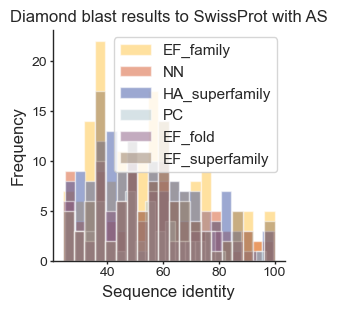

In [89]:
from Bio import AlignIO
import matplotlib.pyplot as plt
import numpy as np

# OK here we need to have all the swiss prot since we're searching fro both the test and the training to this set
# so this is just uniprot to the active sites
uniprot_id_to_active_site = dict(zip(swissprot['Entry'], swissprot['Residue']))

dataset_to_blast = {}
missing_blast_seq = pd.DataFrame()
total_missing, total_found = 0, 0

for di, df_label in enumerate(order):
    df_label = df_label + '_BLAST.pkl'
    df = results[df_label]
    predicted_active_sites = {}
    missing, found = 0, 0
    missing_entries = []
    for query, uniprot in df[['From', 'target']].values:
        if not uniprot or not isinstance(uniprot, str):
            missing += 1
            missing_entries.append(query)
        else:
            fin = f'msa/{uniprot}_{query}.msa'
            # Read with bioseq
            # Read the alignment
            active_sites = [int(x) for x in uniprot_id_to_active_site.get(uniprot).split('|')]
            alignment = AlignIO.read(fin, 'fasta')
            # get the existing one and then calculate the position gapped
            records = {}
            for record in alignment:
                records[record.id] = record.seq
            # Now get the active site
            position_count = 0
            active_pred = []
            query_seq = records[query]
            query_count = 0
            x = 0
            for i, v in enumerate(records[uniprot]):
                if position_count in active_sites:
                    if query_count < len(query_seq.replace('-', '')):
                        active_pred.append(query_count)
                    if query_seq[i] != v:
                        x += 1
                        #print(query, uniprot, v, query_seq[i])
                if v != '-':
                    position_count += 1
                if query_seq[i] != '-' and query_seq[i] != ' ':
                    query_count += 1
        
            predicted_active_sites[query] = '|'.join([str(s) for s in active_pred])
            found += 1
            # Now we can just add on the
        # except:
        #     missing += 1
    
    df['BLAST_residues'] = [predicted_active_sites.get(label) for label in df['From'].values]
    df['True_residues'] = [uniprot_id_to_active_site.get(label) for label in df['From'].values]
    results[df_label] = df
    
    df.to_csv(f'data/AEGAN/blast/{df_label.replace(".pkl", ".csv")}')
    u.warn_p(['Missing a BLAST sequence: ', missing, 'Found with BLAST sequences:', found])
    # Check the agreement:
    precision, recall, f1, support, agree, disagree, no_pred, mean_agreement = calculate_stats(df, 'From', 'True_residues', 'BLAST_residues', 'Sequence')
    dataset_to_blast[df_label.replace("_BLAST.pkl", "")] = {'recall': recall, 'f1': f1, 'precision': precision}
    
    # Keep track of the ones with missing BLAST and we'll check Squidly on these
    missing_df = df[df['From'].isin(missing_entries)]
    missing_df['Label'] = df_label.replace("_BLAST.pkl", "")
    missing_blast_seq = pd.concat([missing_df, missing_blast_seq])
    
    u.dp([df_label.replace("_BLAST.pkl", ""), '\nF1', f1, '\nprecision:', precision, '\n recall:', recall])
    # Add the seq identity plot
    plt.hist(df['sequence identity'].values, bins=20, label=df_label.replace("_BLAST.pkl", ""), color=colors[di], alpha=0.5)
    total_missing += missing
    total_found += found

plt.title('Diamond blast results to SwissProt with AS')
plt.legend()
ax = clean_plt(plt.gca())
plt.ylabel('Frequency')
plt.xlabel('Sequence identity')
print(total_missing)
plt.savefig(f'figures/DiamondBlast_histogram_{f}.svg')

In [90]:
def ensemble_predictions(df, blast_col, squidly_col, seq_id_col, squidly_similarity_cutoff=30):
    # Basically we update the choice of blast and squidly based on the cutoff 
    chosen_residues = []
    for blast_res, squidly_res, seq_id in df[[blast_col, squidly_col, seq_id_col]].values:
        # Also check if both are here otherwise pick the other one that was predicted
        if not isinstance(blast_res, str):
            chosen_residues.append(squidly_res)
        elif not isinstance(squidly_res, str):
            chosen_residues.append(blast_res)
        elif seq_id < squidly_similarity_cutoff:
            chosen_residues.append(squidly_res)
        elif seq_id >= squidly_similarity_cutoff:
            chosen_residues.append(blast_res)
        else:
            chosen_residues.append(None)
    df['chosen_residues'] = chosen_residues
    return df

rows = []
entry_to_squidly_prediction = {}
for squidly_cutoff in tqdm(range(0, 100, 2)):
    for df_label in results:
        if df_label == 'label':
            continue
        df = results[df_label]
        squidly_df = pd.read_pickle(f'data/Squidly/{df_label.replace("_BLAST.pkl", "")}_squidly_as_pred_3B.pkl')
        squidly_df.set_index('label', inplace=True)
        df = df.join(squidly_df, how='left')
        for query, pred in df[['From', 'Squidly_CR_Position']].values:
            entry_to_squidly_prediction[query] = pred
        # 'From', 'True_residues', 'BLAST_residues', 'Sequence'
        tmp_df = ensemble_predictions(df, 'BLAST_residues', 'Squidly_CR_Position', 'sequence identity', squidly_cutoff)
        precision, recall, f1, support, agree, disagree, no_pred, mean_agreement = calculate_stats(tmp_df, 'From', 'True_residues', 'chosen_residues', 'Sequence')
        rows.append([df_label.replace(".pkl", ""), squidly_cutoff, f1, precision, recall, support, agree, disagree, no_pred, mean_agreement])


  0%|                                                                                                                                     | 0/50 [00:00<?, ?it/s]

You were missing N reference sequences: 0
[0.99943592 0.86253369] 0.8625336927223719
You were missing N reference sequences: 0
[0.99944812 0.87198516] 0.8719851576994433
You were missing N reference sequences: 0
[0.99950335 0.89119171] 0.8911917098445595
You were missing N reference sequences: 0
[0.99962926 0.91640867] 0.9164086687306501
You were missing N reference sequences: 0
[0.99954787 0.89882353] 0.8988235294117647
You were missing N reference sequences: 0
[0.9994501  0.87078652] 0.8707865168539326


  2%|██▌                                                                                                                          | 1/50 [00:00<00:10,  4.55it/s]

You were missing N reference sequences: 0
[0.99943592 0.86253369] 0.8625336927223719
You were missing N reference sequences: 0
[0.99944812 0.87198516] 0.8719851576994433
You were missing N reference sequences: 0
[0.99950335 0.89119171] 0.8911917098445595
You were missing N reference sequences: 0
[0.99962926 0.91640867] 0.9164086687306501
You were missing N reference sequences: 0
[0.99954787 0.89882353] 0.8988235294117647
You were missing N reference sequences: 0
[0.9994501  0.87078652] 0.8707865168539326


  4%|█████                                                                                                                        | 2/50 [00:00<00:10,  4.60it/s]

You were missing N reference sequences: 0
[0.99943592 0.86253369] 0.8625336927223719
You were missing N reference sequences: 0
[0.99944812 0.87198516] 0.8719851576994433
You were missing N reference sequences: 0
[0.99950335 0.89119171] 0.8911917098445595
You were missing N reference sequences: 0
[0.99962926 0.91640867] 0.9164086687306501
You were missing N reference sequences: 0
[0.99954787 0.89882353] 0.8988235294117647
You were missing N reference sequences: 0


  6%|███████▌                                                                                                                     | 3/50 [00:00<00:10,  4.61it/s]

[0.9994501  0.87078652] 0.8707865168539326
You were missing N reference sequences: 0
[0.99943592 0.86253369] 0.8625336927223719
You were missing N reference sequences: 0
[0.99944812 0.87198516] 0.8719851576994433
You were missing N reference sequences: 0
[0.99950335 0.89119171] 0.8911917098445595
You were missing N reference sequences: 0
[0.99962926 0.91640867] 0.9164086687306501
You were missing N reference sequences: 0
[0.99954787 0.89882353] 0.8988235294117647
You were missing N reference sequences: 0


  8%|██████████                                                                                                                   | 4/50 [00:00<00:09,  4.64it/s]

[0.9994501  0.87078652] 0.8707865168539326
You were missing N reference sequences: 0
[0.99943592 0.86253369] 0.8625336927223719
You were missing N reference sequences: 0
[0.99944812 0.87198516] 0.8719851576994433
You were missing N reference sequences: 0
[0.99950335 0.89119171] 0.8911917098445595
You were missing N reference sequences: 0
[0.99962926 0.91640867] 0.9164086687306501
You were missing N reference sequences: 0
[0.99954787 0.89882353] 0.8988235294117647
You were missing N reference sequences: 0


 10%|████████████▌                                                                                                                | 5/50 [00:01<00:09,  4.63it/s]

[0.9994501  0.87078652] 0.8707865168539326
You were missing N reference sequences: 0
[0.99943592 0.86253369] 0.8625336927223719
You were missing N reference sequences: 0
[0.99944812 0.87198516] 0.8719851576994433
You were missing N reference sequences: 0
[0.99950335 0.89119171] 0.8911917098445595
You were missing N reference sequences: 0
[0.99962926 0.91640867] 0.9164086687306501
You were missing N reference sequences: 0
[0.99954787 0.89882353] 0.8988235294117647
You were missing N reference sequences: 0


 12%|███████████████                                                                                                              | 6/50 [00:01<00:09,  4.60it/s]

[0.9994501  0.87078652] 0.8707865168539326
You were missing N reference sequences: 0
[0.99943592 0.86253369] 0.8625336927223719
You were missing N reference sequences: 0
[0.99944812 0.87198516] 0.8719851576994433
You were missing N reference sequences: 0
[0.99950335 0.89119171] 0.8911917098445595
You were missing N reference sequences: 0
[0.99962926 0.91640867] 0.9164086687306501
You were missing N reference sequences: 0
[0.99954787 0.89882353] 0.8988235294117647
You were missing N reference sequences: 0


 14%|█████████████████▌                                                                                                           | 7/50 [00:01<00:09,  4.54it/s]

[0.9994501  0.87078652] 0.8707865168539326
You were missing N reference sequences: 0
[0.99943592 0.86253369] 0.8625336927223719
You were missing N reference sequences: 0
[0.99944812 0.87198516] 0.8719851576994433
You were missing N reference sequences: 0
[0.99950335 0.89119171] 0.8911917098445595
You were missing N reference sequences: 0
[0.99962926 0.91640867] 0.9164086687306501
You were missing N reference sequences: 0
[0.99954787 0.89882353] 0.8988235294117647
You were missing N reference sequences: 0


 16%|████████████████████                                                                                                         | 8/50 [00:01<00:09,  4.58it/s]

[0.9994501  0.87078652] 0.8707865168539326
You were missing N reference sequences: 0
[0.99943592 0.86253369] 0.8625336927223719
You were missing N reference sequences: 0
[0.99944812 0.87198516] 0.8719851576994433
You were missing N reference sequences: 0
[0.99950335 0.89119171] 0.8911917098445595
You were missing N reference sequences: 0
[0.99962926 0.91640867] 0.9164086687306501
You were missing N reference sequences: 0
[0.99954787 0.89882353] 0.8988235294117647
You were missing N reference sequences: 0


 18%|██████████████████████▌                                                                                                      | 9/50 [00:01<00:08,  4.57it/s]

[0.9994501  0.87078652] 0.8707865168539326
You were missing N reference sequences: 0
[0.99943592 0.86253369] 0.8625336927223719
You were missing N reference sequences: 0
[0.99944812 0.87198516] 0.8719851576994433
You were missing N reference sequences: 0
[0.99950335 0.89119171] 0.8911917098445595
You were missing N reference sequences: 0
[0.99962926 0.91640867] 0.9164086687306501
You were missing N reference sequences: 0
[0.99954787 0.89882353] 0.8988235294117647
You were missing N reference sequences: 0


 20%|████████████████████████▊                                                                                                   | 10/50 [00:02<00:08,  4.59it/s]

[0.9994501  0.87078652] 0.8707865168539326
You were missing N reference sequences: 0
[0.99943592 0.86253369] 0.8625336927223719
You were missing N reference sequences: 0
[0.99944812 0.87198516] 0.8719851576994433
You were missing N reference sequences: 0
[0.99950335 0.89119171] 0.8911917098445595
You were missing N reference sequences: 0
[0.99962926 0.91640867] 0.9164086687306501
You were missing N reference sequences: 0
[0.99954787 0.89882353] 0.8988235294117647
You were missing N reference sequences: 0


 22%|███████████████████████████▎                                                                                                | 11/50 [00:02<00:08,  4.60it/s]

[0.9994501  0.87078652] 0.8707865168539326
You were missing N reference sequences: 0
[0.99943592 0.86253369] 0.8625336927223719
You were missing N reference sequences: 0
[0.99944812 0.87198516] 0.8719851576994433
You were missing N reference sequences: 0
[0.99950335 0.89119171] 0.8911917098445595
You were missing N reference sequences: 0
[0.99962926 0.91640867] 0.9164086687306501
You were missing N reference sequences: 0
[0.99954787 0.89882353] 0.8988235294117647
You were missing N reference sequences: 0


 24%|█████████████████████████████▊                                                                                              | 12/50 [00:02<00:08,  4.60it/s]

[0.9994501  0.87078652] 0.8707865168539326
You were missing N reference sequences: 0
[0.99943592 0.86253369] 0.8625336927223719
You were missing N reference sequences: 0
[0.99944812 0.87198516] 0.8719851576994433
You were missing N reference sequences: 0
[0.99950335 0.89119171] 0.8911917098445595
You were missing N reference sequences: 0
[0.99962926 0.91640867] 0.9164086687306501
You were missing N reference sequences: 0
[0.99954787 0.89882353] 0.8988235294117647
You were missing N reference sequences: 0


 26%|████████████████████████████████▏                                                                                           | 13/50 [00:02<00:08,  4.61it/s]

[0.9994501  0.87078652] 0.8707865168539326
You were missing N reference sequences: 0
[0.9994691  0.87096774] 0.870967741935484
You were missing N reference sequences: 0
[0.99945612 0.87360595] 0.8736059479553903
You were missing N reference sequences: 0
[0.99952701 0.89583333] 0.8958333333333334
You were missing N reference sequences: 0
[0.99958806 0.90740741] 0.9074074074074073
You were missing N reference sequences: 0
[0.99955838 0.90140845] 0.9014084507042253
You were missing N reference sequences: 0


 28%|██████████████████████████████████▋                                                                                         | 14/50 [00:03<00:07,  4.66it/s]

[0.99945608 0.87237027] 0.8723702664796635
You were missing N reference sequences: 0
[0.9994691  0.87096774] 0.870967741935484
You were missing N reference sequences: 0
[0.99945612 0.87360595] 0.8736059479553903
You were missing N reference sequences: 0
[0.99952701 0.89583333] 0.8958333333333334
You were missing N reference sequences: 0
[0.99958806 0.90740741] 0.9074074074074073
You were missing N reference sequences: 0
[0.9995689  0.90352941] 0.9035294117647059
You were missing N reference sequences: 0


 30%|█████████████████████████████████████▏                                                                                      | 15/50 [00:03<00:07,  4.64it/s]

[0.99946206 0.87359551] 0.8735955056179775
You were missing N reference sequences: 0
[0.99948016 0.87331536] 0.8733153638814017
You were missing N reference sequences: 0
[0.99941614 0.86405959] 0.8640595903165736
You were missing N reference sequences: 0
[0.99955067 0.90052356] 0.9005235602094241
You were missing N reference sequences: 0
[0.99953313 0.89506173] 0.8950617283950616
You were missing N reference sequences: 0
[0.9995689  0.90352941] 0.9035294117647059
You were missing N reference sequences: 0


 32%|███████████████████████████████████████▋                                                                                    | 16/50 [00:03<00:07,  4.55it/s]

[0.99945608 0.87201125] 0.8720112517580872
You were missing N reference sequences: 0
[0.99948016 0.87331536] 0.8733153638814017
You were missing N reference sequences: 0
[0.99942414 0.86567164] 0.8656716417910447
You were missing N reference sequences: 0
[0.99955067 0.90052356] 0.9005235602094241
You were missing N reference sequences: 0
[0.99953313 0.89506173] 0.8950617283950616
You were missing N reference sequences: 0
[0.99963199 0.91764706] 0.9176470588235295
You were missing N reference sequences: 0


 34%|██████████████████████████████████████████▏                                                                                 | 17/50 [00:03<00:07,  4.43it/s]

[0.99948597 0.87921348] 0.8792134831460674
You were missing N reference sequences: 0
[0.99949123 0.87567568] 0.8756756756756756
You were missing N reference sequences: 0
[0.99937616 0.85393258] 0.8539325842696629
You were missing N reference sequences: 0
[0.99957433 0.90526316] 0.9052631578947369
You were missing N reference sequences: 0
[0.99953313 0.89506173] 0.8950617283950616
You were missing N reference sequences: 0
[0.9996425  0.91981132] 0.9198113207547169
You were missing N reference sequences: 0


 36%|████████████████████████████████████████████▋                                                                               | 18/50 [00:03<00:07,  4.50it/s]

[0.99945607 0.87272727] 0.8727272727272728
You were missing N reference sequences: 0
[0.99948017 0.87262873] 0.872628726287263
You were missing N reference sequences: 0
[0.99936017 0.84962406] 0.8496240601503758
You were missing N reference sequences: 0
[0.99955069 0.8994709 ] 0.8994708994708994
You were missing N reference sequences: 0
[0.99951941 0.89164087] 0.891640866873065
You were missing N reference sequences: 0
[0.99963199 0.91725768] 0.91725768321513
You were missing N reference sequences: 0


 38%|███████████████████████████████████████████████                                                                             | 19/50 [00:04<00:06,  4.55it/s]

[0.99948596 0.87955182] 0.8795518207282914
You were missing N reference sequences: 0
[0.99948017 0.87262873] 0.872628726287263
You were missing N reference sequences: 0
[0.99937617 0.85338346] 0.8533834586466166
You were missing N reference sequences: 0
[0.99952703 0.89473684] 0.8947368421052632
You were missing N reference sequences: 0
[0.99949193 0.88615385] 0.8861538461538461
You were missing N reference sequences: 0
[0.99961096 0.91252955] 0.9125295508274233
You were missing N reference sequences: 0


 40%|█████████████████████████████████████████████████▌                                                                          | 20/50 [00:04<00:06,  4.58it/s]

[0.99949791 0.88235294] 0.8823529411764706
You were missing N reference sequences: 0
[0.99949123 0.87567568] 0.8756756756756756
You were missing N reference sequences: 0
[0.99939217 0.85714286] 0.8571428571428571
You were missing N reference sequences: 0
[0.99952703 0.89473684] 0.8947368421052632
You were missing N reference sequences: 0
[0.99950566 0.88957055] 0.8895705521472393
You were missing N reference sequences: 0
[0.99962149 0.91428571] 0.9142857142857143
You were missing N reference sequences: 0


 42%|████████████████████████████████████████████████████                                                                        | 21/50 [00:04<00:06,  4.63it/s]

[0.99953379 0.89014085] 0.8901408450704226
You were missing N reference sequences: 0
[0.99951336 0.88043478] 0.8804347826086957
You were missing N reference sequences: 0
[0.9993682  0.85009488] 0.8500948766603417
You were missing N reference sequences: 0
[0.99957433 0.90526316] 0.9052631578947369
You were missing N reference sequences: 0
[0.99953312 0.89570552] 0.8957055214723927
You were missing N reference sequences: 0
[0.99964252 0.91904762] 0.919047619047619
You were missing N reference sequences: 0


 44%|██████████████████████████████████████████████████████▌                                                                     | 22/50 [00:04<00:06,  4.65it/s]

[0.99952184 0.88700565] 0.8870056497175142
You were missing N reference sequences: 0
[0.99951336 0.88043478] 0.8804347826086957
You were missing N reference sequences: 0
[0.99935219 0.84688091] 0.8468809073724006
You were missing N reference sequences: 0
[0.99957433 0.90526316] 0.9052631578947369
You were missing N reference sequences: 0
[0.99950567 0.88888889] 0.8888888888888888
You were missing N reference sequences: 0
[0.99964252 0.91904762] 0.919047619047619
You were missing N reference sequences: 0


 46%|█████████████████████████████████████████████████████████                                                                   | 23/50 [00:05<00:05,  4.65it/s]

[0.99951587 0.8854314 ] 0.8854314002828854
You were missing N reference sequences: 0
[0.99952442 0.88346883] 0.8834688346883469
You were missing N reference sequences: 0
[0.99937618 0.85283019] 0.8528301886792453
You were missing N reference sequences: 0
[0.99959797 0.91099476] 0.9109947643979057
You were missing N reference sequences: 0
[0.99949193 0.88615385] 0.8861538461538461
You were missing N reference sequences: 0
[0.999632   0.91686461] 0.9168646080760093
You were missing N reference sequences: 0


 48%|███████████████████████████████████████████████████████████▌                                                                | 24/50 [00:05<00:05,  4.64it/s]

[0.99948598 0.87853107] 0.8785310734463276
You were missing N reference sequences: 0
[0.99951335 0.88108108] 0.8810810810810811
You were missing N reference sequences: 0
[0.99933621 0.84250474] 0.8425047438330171
You were missing N reference sequences: 0
[0.99957431 0.90625   ] 0.90625
You were missing N reference sequences: 0
[0.99945076 0.8757764 ] 0.8757763975155278
You were missing N reference sequences: 0
[0.99955842 0.89903846] 0.8990384615384615
You were missing N reference sequences: 0


 50%|██████████████████████████████████████████████████████████████                                                              | 25/50 [00:05<00:05,  4.65it/s]

[0.9994322  0.86486486] 0.8648648648648648
You were missing N reference sequences: 0
[0.99945807 0.86648501] 0.8664850136239782
You were missing N reference sequences: 0
[0.99926426 0.82375479] 0.8237547892720307
You were missing N reference sequences: 0
[0.99952705 0.89361702] 0.8936170212765958
You were missing N reference sequences: 0
[0.99932723 0.84542587] 0.8454258675078864
You were missing N reference sequences: 0
[0.99945331 0.87378641] 0.8737864077669902
You were missing N reference sequences: 0


 52%|████████████████████████████████████████████████████████████████▍                                                           | 26/50 [00:05<00:05,  4.64it/s]

[0.99940829 0.85957447] 0.8595744680851064
You were missing N reference sequences: 0
[0.99945807 0.86648501] 0.8664850136239782
You were missing N reference sequences: 0
[0.99926426 0.82375479] 0.8237547892720307
You were missing N reference sequences: 0
[0.99952705 0.89361702] 0.8936170212765958
You were missing N reference sequences: 0
[0.99929979 0.83809524] 0.8380952380952381
You were missing N reference sequences: 0
[0.9994428  0.87104623] 0.8710462287104623
You were missing N reference sequences: 0


 54%|██████████████████████████████████████████████████████████████████▉                                                         | 27/50 [00:05<00:04,  4.64it/s]

[0.99939036 0.85511364] 0.8551136363636364
You were missing N reference sequences: 0
[0.999447   0.86413043] 0.8641304347826086
You were missing N reference sequences: 0
[0.99926426 0.82375479] 0.8237547892720307
You were missing N reference sequences: 0
[0.99952705 0.89361702] 0.8936170212765958
You were missing N reference sequences: 0
[0.99929979 0.83809524] 0.8380952380952381
You were missing N reference sequences: 0
[0.9994428  0.87104623] 0.8710462287104623
You were missing N reference sequences: 0


 56%|█████████████████████████████████████████████████████████████████████▍                                                      | 28/50 [00:06<00:04,  4.68it/s]

[0.99939036 0.85511364] 0.8551136363636364
You were missing N reference sequences: 0
[0.99941383 0.85558583] 0.8555858310626703
You were missing N reference sequences: 0
[0.99921629 0.81153846] 0.8115384615384614
You were missing N reference sequences: 0
[0.99952705 0.89361702] 0.8936170212765958
You were missing N reference sequences: 0
[0.99924489 0.82428115] 0.8242811501597443
You were missing N reference sequences: 0
[0.99941127 0.86341463] 0.8634146341463416
You were missing N reference sequences: 0


 58%|███████████████████████████████████████████████████████████████████████▉                                                    | 29/50 [00:06<00:04,  4.65it/s]

[0.99931267 0.83594864] 0.8359486447931526
You were missing N reference sequences: 0
[0.99941383 0.85558583] 0.8555858310626703
You were missing N reference sequences: 0
[0.99918431 0.8030888 ] 0.803088803088803
You were missing N reference sequences: 0
[0.99952705 0.89361702] 0.8936170212765958
You were missing N reference sequences: 0
[0.99923117 0.82051282] 0.8205128205128205
You were missing N reference sequences: 0
[0.99935868 0.85230024] 0.8523002421307506
You were missing N reference sequences: 0


 60%|██████████████████████████████████████████████████████████████████████████▍                                                 | 30/50 [00:06<00:04,  4.61it/s]

[0.99928875 0.83120567] 0.8312056737588652
You were missing N reference sequences: 0
[0.99941383 0.85558583] 0.8555858310626703
You were missing N reference sequences: 0
[0.99918431 0.8030888 ] 0.803088803088803
You were missing N reference sequences: 0
[0.99952705 0.89361702] 0.8936170212765958
You were missing N reference sequences: 0
[0.99921745 0.81672026] 0.8167202572347266
You were missing N reference sequences: 0
[0.99933767 0.84671533] 0.8467153284671532
You were missing N reference sequences: 0


 62%|████████████████████████████████████████████████████████████████████████████▉                                               | 31/50 [00:06<00:04,  4.64it/s]

[0.99928875 0.83120567] 0.8312056737588652
You were missing N reference sequences: 0
[0.99930318 0.8310992 ] 0.8310991957104559
You were missing N reference sequences: 0
[0.9991043  0.78625954] 0.7862595419847328
You were missing N reference sequences: 0
[0.99938508 0.86597938] 0.865979381443299
You were missing N reference sequences: 0
[0.99920371 0.81410256] 0.814102564102564
You were missing N reference sequences: 0
[0.9992956 0.8377724] 0.8377723970944311
You were missing N reference sequences: 0


 64%|███████████████████████████████████████████████████████████████████████████████▎                                            | 32/50 [00:06<00:03,  4.58it/s]

[0.99926483 0.82602546] 0.826025459688826
You were missing N reference sequences: 0
[0.99929213 0.82795699] 0.8279569892473119
You were missing N reference sequences: 0
[0.99909631 0.78393881] 0.7839388145315487
You were missing N reference sequences: 0
[0.99936145 0.86010363] 0.8601036269430052
You were missing N reference sequences: 0
[0.99920371 0.81410256] 0.814102564102564
You were missing N reference sequences: 0
[0.9992851  0.83495146] 0.8349514563106796
You were missing N reference sequences: 0


 66%|█████████████████████████████████████████████████████████████████████████████████▊                                          | 33/50 [00:07<00:03,  4.61it/s]

[0.99924692 0.82102273] 0.8210227272727273
You were missing N reference sequences: 0
[0.99927001 0.82258065] 0.8225806451612904
You were missing N reference sequences: 0
[0.99908032 0.78011472] 0.780114722753346
You were missing N reference sequences: 0
[0.99936145 0.86010363] 0.8601036269430052
You were missing N reference sequences: 0
[0.99920371 0.81410256] 0.814102564102564
You were missing N reference sequences: 0
[0.99930611 0.84057971] 0.8405797101449275
You were missing N reference sequences: 0


 68%|████████████████████████████████████████████████████████████████████████████████████▎                                       | 34/50 [00:07<00:03,  4.63it/s]

[0.99926483 0.82602546] 0.826025459688826
You were missing N reference sequences: 0
[0.99927001 0.82258065] 0.8225806451612904
You were missing N reference sequences: 0
[0.99908032 0.78011472] 0.780114722753346
You were missing N reference sequences: 0
[0.99933781 0.85416667] 0.8541666666666666
You were missing N reference sequences: 0
[0.99920371 0.81410256] 0.814102564102564
You were missing N reference sequences: 0
[0.99930611 0.84057971] 0.8405797101449275
You were missing N reference sequences: 0


 70%|██████████████████████████████████████████████████████████████████████████████████████▊                                     | 35/50 [00:07<00:03,  4.59it/s]

[0.99925885 0.82485876] 0.8248587570621468
You were missing N reference sequences: 0
[0.9992368 0.816    ] 0.8160000000000001
You were missing N reference sequences: 0
[0.9990563 0.7756654] 0.7756653992395437
You were missing N reference sequences: 0
[0.99933781 0.85416667] 0.8541666666666666
You were missing N reference sequences: 0
[0.99920371 0.81410256] 0.814102564102564
You were missing N reference sequences: 0
[0.9992851  0.83495146] 0.8349514563106796
You were missing N reference sequences: 0


 72%|█████████████████████████████████████████████████████████████████████████████████████████▎                                  | 36/50 [00:07<00:03,  4.60it/s]

[0.99922896 0.8180536 ] 0.8180535966149506
You were missing N reference sequences: 0
[0.99922573 0.81382979] 0.8138297872340425
You were missing N reference sequences: 0
[0.99904029 0.77272727] 0.7727272727272726
You were missing N reference sequences: 0
[0.99931415 0.84974093] 0.8497409326424871
You were missing N reference sequences: 0
[0.99917628 0.80645161] 0.8064516129032258
You were missing N reference sequences: 0
[0.9992851  0.83495146] 0.8349514563106796
You were missing N reference sequences: 0


 74%|███████████████████████████████████████████████████████████████████████████████████████████▊                                | 37/50 [00:08<00:02,  4.63it/s]

[0.99921702 0.81471004] 0.8147100424328146
You were missing N reference sequences: 0
[0.99921468 0.81066667] 0.8106666666666666
You were missing N reference sequences: 0
[0.99903229 0.77126654] 0.771266540642722
You were missing N reference sequences: 0
[0.99931415 0.84974093] 0.8497409326424871
You were missing N reference sequences: 0
[0.99917628 0.80645161] 0.8064516129032258
You were missing N reference sequences: 0
[0.99927458 0.83292978] 0.8329297820823244
You were missing N reference sequences: 0


 76%|██████████████████████████████████████████████████████████████████████████████████████████████▏                             | 38/50 [00:08<00:02,  4.63it/s]

[0.99921105 0.81303116] 0.813031161473088
You were missing N reference sequences: 0
[0.99921468 0.81066667] 0.8106666666666666
You were missing N reference sequences: 0
[0.99903229 0.77126654] 0.771266540642722
You were missing N reference sequences: 0
[0.99931415 0.84974093] 0.8497409326424871
You were missing N reference sequences: 0
[0.99914884 0.7987013 ] 0.7987012987012987
You were missing N reference sequences: 0
[0.99925357 0.82725061] 0.827250608272506
You were missing N reference sequences: 0


 78%|████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 39/50 [00:08<00:02,  4.66it/s]

[0.9991991  0.80965909] 0.8096590909090908
You were missing N reference sequences: 0
[0.99918149 0.80319149] 0.8031914893617021
You were missing N reference sequences: 0
[0.9990243  0.76893939] 0.7689393939393939
You were missing N reference sequences: 0
[0.99924318 0.83505155] 0.8350515463917525
You were missing N reference sequences: 0
[0.99910765 0.78964401] 0.7896440129449839
You were missing N reference sequences: 0
[0.99922202 0.82038835] 0.8203883495145631
You were missing N reference sequences: 0


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 40/50 [00:08<00:02,  4.63it/s]

[0.99916921 0.80283688] 0.8028368794326242
You were missing N reference sequences: 0
[0.99917042 0.80106101] 0.8010610079575596
You were missing N reference sequences: 0
[0.99899232 0.76045627] 0.7604562737642586
You were missing N reference sequences: 0
[0.99924318 0.83505155] 0.8350515463917525
You were missing N reference sequences: 0
[0.99909393 0.78571429] 0.7857142857142856
You were missing N reference sequences: 0
[0.99921151 0.81751825] 0.8175182481751825
You were missing N reference sequences: 0


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 41/50 [00:08<00:01,  4.67it/s]

[0.99916324 0.80113636] 0.8011363636363638
You were missing N reference sequences: 0
[0.99915937 0.79787234] 0.7978723404255318
You were missing N reference sequences: 0
[0.99898433 0.75809524] 0.758095238095238
You were missing N reference sequences: 0
[0.99924318 0.83505155] 0.8350515463917525
You were missing N reference sequences: 0
[0.99909393 0.78571429] 0.7857142857142856
You were missing N reference sequences: 0
[0.99921151 0.81751825] 0.8175182481751825
You were missing N reference sequences: 0


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 42/50 [00:09<00:01,  4.66it/s]

[0.99916324 0.80113636] 0.8011363636363638
You were missing N reference sequences: 0
[0.99915937 0.79787234] 0.7978723404255318
You were missing N reference sequences: 0
[0.99897634 0.75572519] 0.7557251908396946
You were missing N reference sequences: 0
[0.99924318 0.83505155] 0.8350515463917525
You were missing N reference sequences: 0
[0.99909393 0.78571429] 0.7857142857142856
You were missing N reference sequences: 0
[0.99921151 0.81751825] 0.8175182481751825
You were missing N reference sequences: 0


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 43/50 [00:09<00:01,  4.67it/s]

[0.99915726 0.8       ] 0.7999999999999999
You were missing N reference sequences: 0
[0.99915937 0.79787234] 0.7978723404255318
You were missing N reference sequences: 0
[0.99896834 0.75428571] 0.7542857142857142
You were missing N reference sequences: 0
[0.99924318 0.83505155] 0.8350515463917525
You were missing N reference sequences: 0
[0.99909393 0.78571429] 0.7857142857142856
You were missing N reference sequences: 0
[0.99921151 0.81751825] 0.8175182481751825
You were missing N reference sequences: 0


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 44/50 [00:09<00:01,  4.68it/s]

[0.99915128 0.79886686] 0.7988668555240793
You were missing N reference sequences: 0
[0.99915937 0.79787234] 0.7978723404255318
You were missing N reference sequences: 0
[0.99896035 0.7519084 ] 0.7519083969465647
You were missing N reference sequences: 0
[0.99924318 0.83505155] 0.8350515463917525
You were missing N reference sequences: 0
[0.99908021 0.78175896] 0.7817589576547233
You were missing N reference sequences: 0
[0.99920101 0.81463415] 0.8146341463414634
You were missing N reference sequences: 0


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 45/50 [00:09<00:01,  4.66it/s]

[0.9991453  0.79716312] 0.7971631205673759
You were missing N reference sequences: 0
[0.99915937 0.79787234] 0.7978723404255318
You were missing N reference sequences: 0
[0.99896035 0.7519084 ] 0.7519083969465647
You were missing N reference sequences: 0
[0.99924318 0.83505155] 0.8350515463917525
You were missing N reference sequences: 0
[0.99908021 0.78175896] 0.7817589576547233
You were missing N reference sequences: 0
[0.99920101 0.81463415] 0.8146341463414634
You were missing N reference sequences: 0


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 46/50 [00:09<00:00,  4.66it/s]

[0.9991453  0.79716312] 0.7971631205673759
You were missing N reference sequences: 0
[0.99915937 0.79787234] 0.7978723404255318
You were missing N reference sequences: 0
[0.99896035 0.7519084 ] 0.7519083969465647
You were missing N reference sequences: 0
[0.99924318 0.83505155] 0.8350515463917525
You were missing N reference sequences: 0
[0.99908021 0.78175896] 0.7817589576547233
You were missing N reference sequences: 0
[0.99920101 0.81463415] 0.8146341463414634
You were missing N reference sequences: 0


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 47/50 [00:10<00:00,  4.63it/s]

[0.99913932 0.79603399] 0.7960339943342776
You were missing N reference sequences: 0
[0.99915937 0.79787234] 0.7978723404255318
You were missing N reference sequences: 0
[0.99896035 0.7519084 ] 0.7519083969465647
You were missing N reference sequences: 0
[0.99924318 0.83505155] 0.8350515463917525
You were missing N reference sequences: 0
[0.99906647 0.77922078] 0.7792207792207791
You were missing N reference sequences: 0
[0.99919049 0.81265207] 0.8126520681265206
You were missing N reference sequences: 0


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 48/50 [00:10<00:00,  4.64it/s]

[0.99913932 0.79603399] 0.7960339943342776
You were missing N reference sequences: 0
[0.99915937 0.79787234] 0.7978723404255318
You were missing N reference sequences: 0
[0.99896035 0.7519084 ] 0.7519083969465647
You were missing N reference sequences: 0
[0.99924318 0.83505155] 0.8350515463917525
You were missing N reference sequences: 0
[0.99906647 0.77922078] 0.7792207792207791
You were missing N reference sequences: 0
[0.99919049 0.81265207] 0.8126520681265206
You were missing N reference sequences: 0
[0.99913932 0.79603399] 0.7960339943342776


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 49/50 [00:10<00:00,  4.69it/s]

You were missing N reference sequences: 0
[0.99914831 0.79466667] 0.7946666666666667
You were missing N reference sequences: 0
[0.99896035 0.7519084 ] 0.7519083969465647
You were missing N reference sequences: 0
[0.99921954 0.82901554] 0.8290155440414508
You were missing N reference sequences: 0
[0.99906647 0.77922078] 0.7792207792207791
You were missing N reference sequences: 0
[0.99919049 0.81265207] 0.8126520681265206
You were missing N reference sequences: 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.62it/s]

[0.99913932 0.79603399] 0.7960339943342776


In [91]:
for df_label in results:
    if df_label == 'label':
        continue
    df = results[df_label]
    squidly_df = pd.read_pickle(f'data/Squidly/{df_label.replace("_BLAST.pkl", "")}_squidly_as_pred_3B.pkl')
    squidly_df.set_index('label', inplace=True)
    df = df.join(squidly_df, how='left')
    for query, pred in df[['From', 'Squidly_CR_Position']].values:
        entry_to_squidly_prediction[query] = pred
    # 'From', 'True_residues', 'BLAST_residues', 'Sequence'
    tmp_df = ensemble_predictions(df, 'BLAST_residues', 'Squidly_CR_Position', 'sequence identity', squidly_cutoff)
    precision, recall, f1, support, agree, disagree, no_pred, mean_agreement = calculate_stats(tmp_df, 'From', 'True_residues', 'chosen_residues', 'Sequence')
    u.dp([df_label.replace("_BLAST.pkl", ""), '\nF1', f1, '\nprecision:', precision, '\n recall:', recall])


You were missing N reference sequences: 0
[0.99914831 0.79466667] 0.7946666666666667
--------------------------------------------------------------------------------
NN	
F1	0.7946666666666667	
precision:	0.8232044198895028	
 recall:	0.7680412371134021	
--------------------------------------------------------------------------------
You were missing N reference sequences: 0
[0.99896035 0.7519084 ] 0.7519083969465647
--------------------------------------------------------------------------------
HA_superfamily	
F1	0.7519083969465647	
precision:	0.7911646586345381	
 recall:	0.7163636363636363	
--------------------------------------------------------------------------------
You were missing N reference sequences: 0
[0.99921954 0.82901554] 0.8290155440414508
--------------------------------------------------------------------------------
PC	
F1	0.8290155440414508	
precision:	0.851063829787234	
 recall:	0.8080808080808081	
--------------------------------------------------------------------

# Check the recovery rate of those 78 sequences 

In [106]:
# No
missing_blast_seq['Squidly_CR_Position'] = [entry_to_squidly_prediction[q] for q in missing_blast_seq['From'].values]
precision, recall, f1, support, agree, disagree, no_pred, mean_agreement = calculate_stats(tmp_df, 'From', 'True_residues', 'Squidly_CR_Position', 'Sequence')
precision, recall, f1, support, agree, disagree, no_pred, mean_agreement

You were missing N reference sequences: 0
[0.9991634  0.79166667] 0.7916666666666667


(0.8778877887788779,
 0.7208672086720868,
 0.7916666666666667,
 369,
 0.6071428571428571,
 0.25,
 0.14285714285714285,
 0.7019557823129251)

In [107]:
df = pd.DataFrame(rows, columns=['Dataset', '% cutoff', 'F1', 'Precision', 'Recall', 'Support', '% fully correct', ' % with difference', ' % missing', 'Mean correct'])
df['Dataset'] = [d.replace('_BLAST', '') for d in df['Dataset'].values]
df.to_csv('data/Ensemble_Squidly_AEGAN_3B.csv', index=False)

In [108]:
def make_figure(df, x, y, hue, filename):
    ax = sns.lineplot(df, x=x, y=y, hue=hue, hue_order=order, palette=colors, legend=None)
    ax.axvline(30, c='black', linestyle = 'dashed')
    ax = sns.scatterplot(df, x=x, y=y, hue=hue, 
                         hue_order=order, ax=ax,
                         palette=colors, s=10, legend=None)
    for i, ds in enumerate(order):
        ax.axhline(dataset_to_blast.get(ds).get(y.lower()), c=colors[i], linestyle='dashed')
    ax = clean_plt(ax)
    plt.title(f'{filename.replace(".svg", "")}')
    plt.ylim(0.45, 1.0)
    plt.xlim(15, 75)
    plt.savefig(f'figures/{filename}')
    plt.show()
    

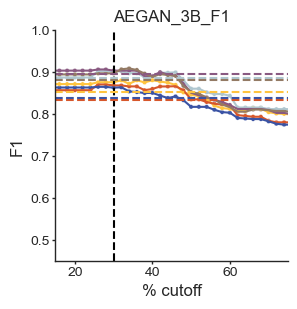

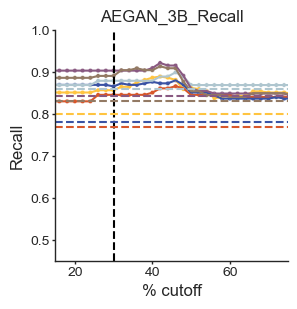

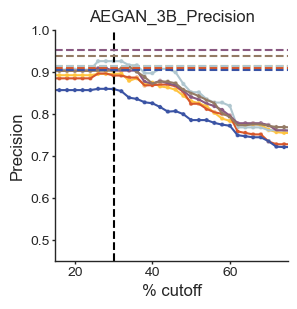

In [109]:
make_figure(df, x='% cutoff', y='F1', hue='Dataset', filename='AEGAN_3B_F1.svg')
make_figure(df, x='% cutoff', y='Recall', hue='Dataset', filename='AEGAN_3B_Recall.svg')
make_figure(df, x='% cutoff', y='Precision', hue='Dataset', filename='AEGAN_3B_Precision.svg')

In [110]:
df[df['% cutoff'] == 30]

,Dataset,% cutoff,F1,Precision,Recall,Support,% fully correct,% with difference,% missing,Mean correct
90,NN,30,0.867725,0.891304,0.845361,194,0.750000,0.212963,0.037037,0.829475
91,HA_superfamily,30,0.862319,0.859206,0.865455,275,0.736842,0.230263,0.032895,0.816557
92,PC,30,0.901554,0.925532,0.878788,99,0.818182,0.163636,0.018182,0.860606
93,EF_fold,30,0.903030,0.903030,0.903030,165,0.774194,0.204301,0.021505,0.848566
94,EF_superfamily,30,0.896552,0.902778,0.890411,219,0.788618,0.186992,0.024390,0.853659
95,EF_family,30,0.875346,0.895184,0.856369,369,0.775510,0.198980,0.025510,0.851616


In [112]:
df[df['% cutoff'] == 0]

,Dataset,% cutoff,F1,Precision,Recall,Support,% fully correct,% with difference,% missing,Mean correct
0,NN,0,0.856383,0.884615,0.829897,194,0.750000,0.222222,0.027778,0.824846
1,HA_superfamily,0,0.862816,0.856631,0.869091,275,0.743421,0.236842,0.019737,0.823136
2,PC,0,0.886598,0.905263,0.868687,99,0.800000,0.200000,0.000000,0.851515
3,EF_fold,0,0.903030,0.903030,0.903030,165,0.784946,0.204301,0.010753,0.853943
4,EF_superfamily,0,0.894009,0.902326,0.885845,219,0.788618,0.186992,0.024390,0.852304
5,EF_family,0,0.871012,0.892045,0.850949,369,0.770408,0.204082,0.025510,0.847364


In [105]:
for df_label in results:
    if df_label == 'label':
        continue
    df = results[df_label]
    squidly_df = pd.read_pickle(f'data/Squidly/{df_label.replace("_BLAST.pkl", "")}_squidly_as_pred_15B.pkl')
    squidly_df.set_index('label', inplace=True)
    df = df.join(squidly_df, how='left')
    for query, pred in df[['From', 'Squidly_CR_Position']].values:
        entry_to_squidly_prediction[query] = pred
    # 'From', 'True_residues', 'BLAST_residues', 'Sequence'
    tmp_df = ensemble_predictions(df, 'BLAST_residues', 'Squidly_CR_Position', 'sequence identity', squidly_cutoff)
    precision, recall, f1, support, agree, disagree, no_pred, mean_agreement = calculate_stats(tmp_df, 'From', 'True_residues', 'chosen_residues', 'Sequence')
    u.dp([df_label.replace("_BLAST.pkl", ""), '\nF1', f1, '\nprecision:', precision, '\n recall:', recall])


You were missing N reference sequences: 0
[0.99918165 0.79329609] 0.7932960893854749
--------------------------------------------------------------------------------
NN	
F1	0.7932960893854749	
precision:	0.8658536585365854	
 recall:	0.7319587628865979	
--------------------------------------------------------------------------------
You were missing N reference sequences: 0
[0.99910446 0.77689243] 0.7768924302788844
--------------------------------------------------------------------------------
HA_superfamily	
F1	0.7768924302788844	
precision:	0.8590308370044053	
 recall:	0.7090909090909091	
--------------------------------------------------------------------------------
You were missing N reference sequences: 0
[0.99917236 0.81283422] 0.8128342245989305
--------------------------------------------------------------------------------
PC	
F1	0.8128342245989305	
precision:	0.8636363636363636	
 recall:	0.7676767676767676	
-------------------------------------------------------------------

In [99]:
rows = []
for squidly_cutoff in tqdm(range(0, 100, 2)):
    for df_label in results:
        if df_label == 'label':
            continue
        df = results[df_label]
        squidly_df = pd.read_pickle(f'data/AEGAN/squidly/squidly_as_pred_15B_{df_label.replace("_BLAST", "")}')
        squidly_df.set_index('label', inplace=True)
        df = df.join(squidly_df, how='left')
        # 'From', 'True_residues', 'BLAST_residues', 'Sequence'
        tmp_df = ensemble_predictions(df, 'BLAST_residues', 'Squidly_CR_Position', 'sequence identity', squidly_cutoff)
        precision, recall, f1, support, agree, disagree, no_pred, mean_agreement = calculate_stats(tmp_df, 'From', 'True_residues', 'chosen_residues', 'Sequence')
        rows.append([df_label.replace(".pkl", ""), squidly_cutoff, f1, precision, recall, support, agree, disagree, no_pred, mean_agreement])


  0%|                                                                                                                                     | 0/50 [00:00<?, ?it/s]

You were missing N reference sequences: 0
[0.99940271 0.85638298] 0.8563829787234043
You were missing N reference sequences: 0
[0.99939206 0.86281588] 0.8628158844765343
You were missing N reference sequences: 0
[0.99947968 0.88659794] 0.88659793814433
You were missing N reference sequences: 0
[0.99956056 0.9030303 ] 0.9030303030303031
You were missing N reference sequences: 0
[0.99951628 0.89400922] 0.8940092165898617
You were missing N reference sequences: 0
[0.9994441  0.87101248]

  2%|██▌                                                                                                                          | 1/50 [00:00<00:10,  4.63it/s]

 0.871012482662968
You were missing N reference sequences: 0
[0.99940271 0.85638298] 0.8563829787234043
You were missing N reference sequences: 0
[0.99939206 0.86281588] 0.8628158844765343
You were missing N reference sequences: 0
[0.99947968 0.88659794] 0.88659793814433
You were missing N reference sequences: 0
[0.99956056 0.9030303 ] 0.9030303030303031
You were missing N reference sequences: 0
[0.99951628 0.89400922] 0.8940092165898617
You were missing N reference sequences: 0


  4%|█████                                                                                                                        | 2/50 [00:00<00:10,  4.66it/s]

[0.9994441  0.87101248] 0.871012482662968
You were missing N reference sequences: 0
[0.99940271 0.85638298] 0.8563829787234043
You were missing N reference sequences: 0
[0.99939206 0.86281588] 0.8628158844765343
You were missing N reference sequences: 0
[0.99947968 0.88659794] 0.88659793814433
You were missing N reference sequences: 0
[0.99956056 0.9030303 ] 0.9030303030303031
You were missing N reference sequences: 0
[0.99951628 0.89400922] 0.8940092165898617
You were missing N reference sequences: 0


  6%|███████▌                                                                                                                     | 3/50 [00:00<00:10,  4.68it/s]

[0.9994441  0.87101248] 0.871012482662968
You were missing N reference sequences: 0
[0.99940271 0.85638298] 0.8563829787234043
You were missing N reference sequences: 0
[0.99939206 0.86281588] 0.8628158844765343
You were missing N reference sequences: 0
[0.99947968 0.88659794] 0.88659793814433
You were missing N reference sequences: 0
[0.99956056 0.9030303 ] 0.9030303030303031
You were missing N reference sequences: 0
[0.99951628 0.89400922] 0.8940092165898617
You were missing N reference sequences: 0


  8%|██████████                                                                                                                   | 4/50 [00:00<00:09,  4.72it/s]

[0.9994441  0.87101248] 0.871012482662968
You were missing N reference sequences: 0
[0.99940271 0.85638298] 0.8563829787234043
You were missing N reference sequences: 0
[0.99939206 0.86281588] 0.8628158844765343
You were missing N reference sequences: 0
[0.99947968 0.88659794] 0.88659793814433
You were missing N reference sequences: 0
[0.99956056 0.9030303 ] 0.9030303030303031
You were missing N reference sequences: 0
[0.99951628 0.89400922] 0.8940092165898617
You were missing N reference sequences: 0


 10%|████████████▌                                                                                                                | 5/50 [00:01<00:09,  4.71it/s]

[0.9994441  0.87101248] 0.871012482662968
You were missing N reference sequences: 0
[0.99940271 0.85638298] 0.8563829787234043
You were missing N reference sequences: 0
[0.99939206 0.86281588] 0.8628158844765343
You were missing N reference sequences: 0
[0.99947968 0.88659794] 0.88659793814433
You were missing N reference sequences: 0
[0.99956056 0.9030303 ] 0.9030303030303031
You were missing N reference sequences: 0
[0.99951628 0.89400922] 0.8940092165898617
You were missing N reference sequences: 0


 12%|███████████████                                                                                                              | 6/50 [00:01<00:09,  4.71it/s]

[0.9994441  0.87101248] 0.871012482662968
You were missing N reference sequences: 0
[0.99940271 0.85638298] 0.8563829787234043
You were missing N reference sequences: 0
[0.99939206 0.86281588] 0.8628158844765343
You were missing N reference sequences: 0
[0.99947968 0.88659794] 0.88659793814433
You were missing N reference sequences: 0
[0.99956056 0.9030303 ] 0.9030303030303031
You were missing N reference sequences: 0
[0.99951628 0.89400922] 0.8940092165898617
You were missing N reference sequences: 0


 14%|█████████████████▌                                                                                                           | 7/50 [00:01<00:09,  4.67it/s]

[0.9994441  0.87101248] 0.871012482662968
You were missing N reference sequences: 0
[0.99940271 0.85638298] 0.8563829787234043
You were missing N reference sequences: 0
[0.99939206 0.86281588] 0.8628158844765343
You were missing N reference sequences: 0
[0.99947968 0.88659794] 0.88659793814433
You were missing N reference sequences: 0
[0.99956056 0.9030303 ] 0.9030303030303031
You were missing N reference sequences: 0
[0.99951628 0.89400922] 0.8940092165898617
You were missing N reference sequences: 0


 16%|████████████████████                                                                                                         | 8/50 [00:01<00:09,  4.66it/s]

[0.9994441  0.87101248] 0.871012482662968
You were missing N reference sequences: 0
[0.99940271 0.85638298] 0.8563829787234043
You were missing N reference sequences: 0
[0.99939206 0.86281588] 0.8628158844765343
You were missing N reference sequences: 0
[0.99947968 0.88659794] 0.88659793814433
You were missing N reference sequences: 0
[0.99956056 0.9030303 ] 0.9030303030303031
You were missing N reference sequences: 0
[0.99951628 0.89400922] 0.8940092165898617
You were missing N reference sequences: 0


 18%|██████████████████████▌                                                                                                      | 9/50 [00:01<00:08,  4.69it/s]

[0.9994441  0.87101248] 0.871012482662968
You were missing N reference sequences: 0
[0.99940271 0.85638298] 0.8563829787234043
You were missing N reference sequences: 0
[0.99939206 0.86281588] 0.8628158844765343
You were missing N reference sequences: 0
[0.99947968 0.88659794] 0.88659793814433
You were missing N reference sequences: 0
[0.99956056 0.9030303 ] 0.9030303030303031
You were missing N reference sequences: 0
[0.99951628 0.89400922] 0.8940092165898617
You were missing N reference sequences: 0


 20%|████████████████████████▊                                                                                                   | 10/50 [00:02<00:08,  4.63it/s]

[0.9994441  0.87101248] 0.871012482662968
You were missing N reference sequences: 0
[0.99940271 0.85638298] 0.8563829787234043
You were missing N reference sequences: 0
[0.99939206 0.86281588] 0.8628158844765343
You were missing N reference sequences: 0
[0.99947968 0.88659794] 0.88659793814433
You were missing N reference sequences: 0
[0.99956056 0.9030303 ] 0.9030303030303031
You were missing N reference sequences: 0
[0.99951628 0.89400922] 0.8940092165898617
You were missing N reference sequences: 0


 22%|███████████████████████████▎                                                                                                | 11/50 [00:02<00:08,  4.65it/s]

[0.9994441  0.87101248] 0.871012482662968
You were missing N reference sequences: 0
[0.99940271 0.85638298] 0.8563829787234043
You were missing N reference sequences: 0
[0.99939206 0.86281588] 0.8628158844765343
You were missing N reference sequences: 0
[0.99947968 0.88659794] 0.88659793814433
You were missing N reference sequences: 0
[0.99956056 0.9030303 ] 0.9030303030303031
You were missing N reference sequences: 0
[0.99951628 0.89400922] 0.8940092165898617
You were missing N reference sequences: 0


 24%|█████████████████████████████▊                                                                                              | 12/50 [00:02<00:08,  4.62it/s]

[0.9994441  0.87101248] 0.871012482662968
You were missing N reference sequences: 0
[0.99940271 0.85638298] 0.8563829787234043
You were missing N reference sequences: 0
[0.99939206 0.86281588] 0.8628158844765343
You were missing N reference sequences: 0
[0.99947968 0.88659794] 0.88659793814433
You were missing N reference sequences: 0
[0.99956056 0.9030303 ] 0.9030303030303031
You were missing N reference sequences: 0
[0.99951628 0.89400922] 0.8940092165898617
You were missing N reference sequences: 0


 26%|████████████████████████████████▏                                                                                           | 13/50 [00:02<00:08,  4.62it/s]

[0.9994441  0.87101248] 0.871012482662968
You were missing N reference sequences: 0
[0.99945801 0.87002653] 0.8700265251989391
You were missing N reference sequences: 0
[0.99940006 0.86437613] 0.864376130198915
You were missing N reference sequences: 0
[0.99955065 0.9015544 ] 0.9015544041450778
You were missing N reference sequences: 0
[0.9995743  0.90577508] 0.9057750759878421
You were missing N reference sequences: 0
[0.99952679 0.89655172] 0.896551724137931
You were missing N reference sequences: 0


 28%|██████████████████████████████████▋                                                                                         | 14/50 [00:03<00:07,  4.64it/s]

[0.99946202 0.87534626] 0.8753462603878117
You were missing N reference sequences: 0
[0.99945801 0.87002653] 0.8700265251989391
You were missing N reference sequences: 0
[0.99940006 0.86437613] 0.864376130198915
You were missing N reference sequences: 0
[0.99955065 0.9015544 ] 0.9015544041450778
You were missing N reference sequences: 0
[0.9995743  0.90577508] 0.9057750759878421
You were missing N reference sequences: 0
[0.99952679 0.89655172] 0.896551724137931
You were missing N reference sequences: 0


 30%|█████████████████████████████████████▏                                                                                      | 15/50 [00:03<00:07,  4.65it/s]

[0.99946202 0.87534626] 0.8753462603878117
You were missing N reference sequences: 0
[0.99944694 0.86772487] 0.8677248677248677
You were missing N reference sequences: 0
[0.99939207 0.86231884] 0.8623188405797101
You were missing N reference sequences: 0
[0.99955065 0.9015544 ] 0.9015544041450778
You were missing N reference sequences: 0
[0.99956056 0.9030303 ] 0.9030303030303031
You were missing N reference sequences: 0
[0.99952679 0.89655172] 0.896551724137931
You were missing N reference sequences: 0


 32%|███████████████████████████████████████▋                                                                                    | 16/50 [00:03<00:07,  4.66it/s]

[0.99946202 0.87534626] 0.8753462603878117
You were missing N reference sequences: 0
[0.99944694 0.86772487] 0.8677248677248677
You were missing N reference sequences: 0
[0.99939205 0.86330935] 0.8633093525179856
You were missing N reference sequences: 0
[0.99955065 0.9015544 ] 0.9015544041450778
You were missing N reference sequences: 0
[0.99956056 0.9030303 ] 0.9030303030303031
You were missing N reference sequences: 0
[0.99956884 0.90617849] 0.9061784897025171
You were missing N reference sequences: 0


 34%|██████████████████████████████████████████▏                                                                                 | 17/50 [00:03<00:07,  4.68it/s]

[0.99947995 0.88      ] 0.8800000000000001
You were missing N reference sequences: 0
[0.99943587 0.86543536] 0.8654353562005278
You were missing N reference sequences: 0
[0.99934403 0.85357143] 0.8535714285714286
You were missing N reference sequences: 0
[0.99952699 0.89690722] 0.8969072164948454
You were missing N reference sequences: 0
[0.99956056 0.9030303 ] 0.9030303030303031
You were missing N reference sequences: 0
[0.99957936 0.90825688] 0.908256880733945
You were missing N reference sequences: 0


 36%|████████████████████████████████████████████▋                                                                               | 18/50 [00:03<00:06,  4.68it/s]

[0.99943808 0.8715847 ] 0.871584699453552
You were missing N reference sequences: 0
[0.99943587 0.86543536] 0.8654353562005278
You were missing N reference sequences: 0
[0.99933603 0.85204991] 0.8520499108734403
You were missing N reference sequences: 0
[0.99952699 0.89690722] 0.8969072164948454
You were missing N reference sequences: 0
[0.99956056 0.9030303 ] 0.9030303030303031
You were missing N reference sequences: 0
[0.99955831 0.90454545] 0.9045454545454545
You were missing N reference sequences: 0


 38%|███████████████████████████████████████████████                                                                             | 19/50 [00:04<00:06,  4.69it/s]

[0.99947394 0.88010899] 0.8801089918256131
You were missing N reference sequences: 0
[0.9993916  0.85639687] 0.8563968668407311
You were missing N reference sequences: 0
[0.99932001 0.84955752] 0.8495575221238938
You were missing N reference sequences: 0
[0.99947966 0.8877551 ] 0.8877551020408163
You were missing N reference sequences: 0
[0.99949186 0.88955224] 0.8895522388059701
You were missing N reference sequences: 0
[0.99951624 0.8959276 ] 0.8959276018099547
You were missing N reference sequences: 0


 40%|█████████████████████████████████████████████████▌                                                                          | 20/50 [00:04<00:06,  4.62it/s]

[0.99944402 0.87483176] 0.8748317631224766
You were missing N reference sequences: 0
[0.99940265 0.859375  ] 0.8593750000000001
You were missing N reference sequences: 0
[0.99931999 0.85008818] 0.8500881834215167
You were missing N reference sequences: 0
[0.99947966 0.8877551 ] 0.8877551020408163
You were missing N reference sequences: 0
[0.99949185 0.89020772] 0.8902077151335313
You were missing N reference sequences: 0
[0.99947415 0.88789238] 0.8878923766816142
You were missing N reference sequences: 0


 42%|████████████████████████████████████████████████████                                                                        | 21/50 [00:04<00:06,  4.63it/s]

[0.99946794 0.88021534] 0.8802153432032301
You were missing N reference sequences: 0
[0.99942477 0.86528497] 0.8652849740932643
You were missing N reference sequences: 0
[0.99928798 0.84358524] 0.843585237258348
You were missing N reference sequences: 0
[0.99952696 0.89795918] 0.8979591836734694
You were missing N reference sequences: 0
[0.99953304 0.89940828] 0.8994082840236686
You were missing N reference sequences: 0
[0.9995057  0.89485459] 0.8948545861297539
You were missing N reference sequences: 0


 44%|██████████████████████████████████████████████████████▌                                                                     | 22/50 [00:04<00:06,  4.67it/s]

[0.99944998 0.87700535] 0.8770053475935828
You were missing N reference sequences: 0
[0.99942477 0.86528497] 0.8652849740932643
You were missing N reference sequences: 0
[0.99925596 0.83769634] 0.8376963350785339
You were missing N reference sequences: 0
[0.99952696 0.89795918] 0.8979591836734694
You were missing N reference sequences: 0
[0.99950558 0.89349112] 0.893491124260355
You were missing N reference sequences: 0
[0.99949518 0.89237668] 0.8923766816143498
You were missing N reference sequences: 0
[0.99943803 0.87433155] 0.8743315508021391


 46%|█████████████████████████████████████████████████████████                                                                   | 23/50 [00:04<00:05,  4.72it/s]

You were missing N reference sequences: 0
[0.99942475 0.86597938] 0.8659793814432989
You were missing N reference sequences: 0
[0.99927195 0.84173913] 0.8417391304347827
You were missing N reference sequences: 0
[0.99952694 0.8989899 ] 0.898989898989899
You were missing N reference sequences: 0
[0.99949184 0.89085546] 0.8908554572271387
You were missing N reference sequences: 0
[0.99948466 0.89038031] 0.890380313199105
You were missing N reference sequences: 0
[0.99941411 0.86898396] 0.8689839572192514


 48%|███████████████████████████████████████████████████████████▌                                                                | 24/50 [00:05<00:05,  4.71it/s]

You were missing N reference sequences: 0
[0.99938049 0.85641026] 0.8564102564102565
You were missing N reference sequences: 0
[0.99923195 0.83275261] 0.832752613240418
You were missing N reference sequences: 0
[0.9994323 0.88     ] 0.88
You were missing N reference sequences: 0
[0.99940945 0.87240356] 0.8724035608308605
You were missing N reference sequences: 0
[0.99937952 0.86681716] 0.8668171557562077
You were missing N reference sequences: 0
[0.99933641 0.85100671] 0.8510067114093959


 50%|██████████████████████████████████████████████████████████████                                                              | 25/50 [00:05<00:05,  4.62it/s]

You were missing N reference sequences: 0
[0.9992809 0.8346056] 0.8346055979643766
You were missing N reference sequences: 0
[0.99915995 0.81675393] 0.8167539267015708
You were missing N reference sequences: 0
[0.99933769 0.86      ] 0.86
You were missing N reference sequences: 0
[0.99931334 0.8502994 ] 0.8502994011976047
You were missing N reference sequences: 0
[0.99931644 0.85193622] 0.8519362186788154
You were missing N reference sequences: 0


 52%|████████████████████████████████████████████████████████████████▍                                                           | 26/50 [00:05<00:05,  4.62it/s]

[0.99930649 0.84574468] 0.8457446808510639
You were missing N reference sequences: 0
[0.9992809 0.8346056] 0.8346055979643766
You were missing N reference sequences: 0
[0.99915995 0.81675393] 0.8167539267015708
You were missing N reference sequences: 0
[0.99933769 0.86      ] 0.86
You were missing N reference sequences: 0
[0.99928587 0.84431138] 0.844311377245509
You were missing N reference sequences: 0
[0.9992954  0.84807256] 0.8480725623582767
You were missing N reference sequences: 0


 54%|██████████████████████████████████████████████████████████████████▉                                                         | 27/50 [00:05<00:04,  4.61it/s]

[0.99928855 0.84196547] 0.8419654714475431
You were missing N reference sequences: 0
[0.99924769 0.82828283] 0.8282828282828284
You were missing N reference sequences: 0
[0.99915995 0.81675393] 0.8167539267015708
You were missing N reference sequences: 0
[0.99929034 0.85148515] 0.8514851485148516
You were missing N reference sequences: 0
[0.99925838 0.83928571] 0.8392857142857144
You were missing N reference sequences: 0
[0.99925333 0.83900227] 0.8390022675736961
You were missing N reference sequences: 0


 56%|█████████████████████████████████████████████████████████████████████▍                                                      | 28/50 [00:06<00:04,  4.63it/s]

[0.99925865 0.83554377] 0.8355437665782494
You were missing N reference sequences: 0
[0.99922554 0.8241206 ] 0.8241206030150755
You were missing N reference sequences: 0
[0.99912795 0.80977312] 0.8097731239092496
You were missing N reference sequences: 0
[0.99926667 0.84729064] 0.8472906403940886
You were missing N reference sequences: 0
[0.99923092 0.83333333] 0.8333333333333334
You were missing N reference sequences: 0
[0.99923228 0.83521445] 0.835214446952596
You were missing N reference sequences: 0


 58%|███████████████████████████████████████████████████████████████████████▉                                                    | 29/50 [00:06<00:04,  4.64it/s]

[0.9991869  0.81962865] 0.8196286472148542
You were missing N reference sequences: 0
[0.99921447 0.82205514] 0.8220551378446116
You were missing N reference sequences: 0
[0.99910396 0.8041958 ] 0.8041958041958043
You were missing N reference sequences: 0
[0.99926667 0.84729064] 0.8472906403940886
You were missing N reference sequences: 0
[0.99920343 0.82840237] 0.8284023668639054
You were missing N reference sequences: 0
[0.9991586  0.82222222] 0.8222222222222222
You were missing N reference sequences: 0


 60%|██████████████████████████████████████████████████████████████████████████▍                                                 | 30/50 [00:06<00:04,  4.62it/s]

[0.99915099 0.81364829] 0.8136482939632547
You were missing N reference sequences: 0
[0.9992034 0.82     ] 0.82
You were missing N reference sequences: 0
[0.99909595 0.80279232] 0.8027923211169284
You were missing N reference sequences: 0
[0.999243   0.84313725] 0.8431372549019608
You were missing N reference sequences: 0
[0.99916219 0.82111437] 0.8211143695014661
You were missing N reference sequences: 0
[0.99912704 0.81596452] 0.8159645232815965
You were missing N reference sequences: 0


 62%|████████████████████████████████████████████████████████████████████████████▉                                               | 31/50 [00:06<00:04,  4.61it/s]

[0.99913901 0.81201044] 0.8120104438642297
You were missing N reference sequences: 0
[0.9990816  0.79706601] 0.7970660146699265
You were missing N reference sequences: 0
[0.99902388 0.79037801] 0.7903780068728522
You were missing N reference sequences: 0
[0.99907725 0.81516588] 0.8151658767772512
You were missing N reference sequences: 0
[0.9991072 0.8115942] 0.8115942028985507
You were missing N reference sequences: 0
[0.99906388 0.80525164] 0.8052516411378556
You were missing N reference sequences: 0


 64%|███████████████████████████████████████████████████████████████████████████████▎                                            | 32/50 [00:06<00:03,  4.64it/s]

[0.99910909 0.80674449] 0.8067444876783398
You were missing N reference sequences: 0
[0.99907053 0.79512195] 0.7951219512195122
You were missing N reference sequences: 0
[0.99901587 0.7890223 ] 0.7890222984562607
You were missing N reference sequences: 0
[0.99907725 0.81516588] 0.8151658767772512
You were missing N reference sequences: 0
[0.9991072 0.8115942] 0.8115942028985507
You were missing N reference sequences: 0
[0.99906388 0.80525164] 0.8052516411378556
You were missing N reference sequences: 0


 66%|█████████████████████████████████████████████████████████████████████████████████▊                                          | 33/50 [00:07<00:03,  4.62it/s]

[0.99910909 0.80674449] 0.8067444876783398
You were missing N reference sequences: 0
[0.99905945 0.79318735] 0.7931873479318734
You were missing N reference sequences: 0
[0.99900786 0.78767123] 0.7876712328767125
You were missing N reference sequences: 0
[0.99907725 0.81516588] 0.8151658767772512
You were missing N reference sequences: 0
[0.9991072 0.8115942] 0.8115942028985507
You were missing N reference sequences: 0
[0.99908489 0.81045752] 0.8104575163398693
You were missing N reference sequences: 0


 68%|████████████████████████████████████████████████████████████████████████████████████▎                                       | 34/50 [00:07<00:03,  4.66it/s]

[0.99913299 0.81290323] 0.8129032258064516
You were missing N reference sequences: 0
[0.99905945 0.79318735] 0.7931873479318734
You were missing N reference sequences: 0
[0.99900786 0.78767123] 0.7876712328767125
You were missing N reference sequences: 0
[0.99907725 0.81516588] 0.8151658767772512
You were missing N reference sequences: 0
[0.9991072 0.8115942] 0.8115942028985507
You were missing N reference sequences: 0
[0.99908489 0.81045752] 0.8104575163398693
You were missing N reference sequences: 0


 70%|██████████████████████████████████████████████████████████████████████████████████████▊                                     | 35/50 [00:07<00:03,  4.65it/s]

[0.999127   0.81185567] 0.8118556701030928
You were missing N reference sequences: 0
[0.99900407 0.78365385] 0.7836538461538463
You were missing N reference sequences: 0
[0.99897582 0.78231293] 0.782312925170068
You were missing N reference sequences: 0
[0.99905357 0.81132075] 0.8113207547169812
You were missing N reference sequences: 0
[0.99909346 0.80924855] 0.8092485549132948
You were missing N reference sequences: 0
[0.99907437 0.80869565] 0.8086956521739131
You were missing N reference sequences: 0


 72%|█████████████████████████████████████████████████████████████████████████████████████████▎                                  | 36/50 [00:07<00:02,  4.69it/s]

[0.99908512 0.80409731] 0.8040973111395646
You were missing N reference sequences: 0
[0.99898192 0.77990431] 0.7799043062200958
You were missing N reference sequences: 0
[0.99893575 0.77647059] 0.776470588235294
You were missing N reference sequences: 0
[0.99905357 0.81132075] 0.8113207547169812
You were missing N reference sequences: 0
[0.99905221 0.80229226] 0.8022922636103152
You were missing N reference sequences: 0
[0.99906384 0.80694143] 0.806941431670282
You were missing N reference sequences: 0


 74%|███████████████████████████████████████████████████████████████████████████████████████████▊                                | 37/50 [00:07<00:02,  4.63it/s]

[0.99906716 0.80102041] 0.8010204081632654
You were missing N reference sequences: 0
[0.99898192 0.77990431] 0.7799043062200958
You were missing N reference sequences: 0
[0.99892776 0.77441077] 0.7744107744107744
You were missing N reference sequences: 0
[0.99905357 0.81132075] 0.8113207547169812
You were missing N reference sequences: 0
[0.99905221 0.80229226] 0.8022922636103152
You were missing N reference sequences: 0
[0.99906384 0.80694143] 0.806941431670282
You were missing N reference sequences: 0


 76%|██████████████████████████████████████████████████████████████████████████████████████████████▏                             | 38/50 [00:08<00:02,  4.63it/s]

[0.99906118 0.8       ] 0.7999999999999999
You were missing N reference sequences: 0
[0.99898192 0.77990431] 0.7799043062200958
You were missing N reference sequences: 0
[0.99892776 0.77441077] 0.7744107744107744
You were missing N reference sequences: 0
[0.99905357 0.81132075] 0.8113207547169812
You were missing N reference sequences: 0
[0.99903849 0.79885057] 0.7988505747126436
You were missing N reference sequences: 0
[0.99905333 0.80434783] 0.8043478260869565
You were missing N reference sequences: 0


 78%|████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 39/50 [00:08<00:02,  4.62it/s]

[0.9990552  0.79846939] 0.7984693877551019
You were missing N reference sequences: 0
[0.99898192 0.77990431] 0.7799043062200958
You were missing N reference sequences: 0
[0.99891977 0.77234401] 0.7723440134907252
You were missing N reference sequences: 0
[0.99905357 0.81132075] 0.8113207547169812
You were missing N reference sequences: 0
[0.99903849 0.79885057] 0.7988505747126436
You were missing N reference sequences: 0
[0.99905333 0.80434783] 0.8043478260869565
You were missing N reference sequences: 0


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 40/50 [00:08<00:02,  4.65it/s]

[0.99904325 0.79591837] 0.7959183673469388
You were missing N reference sequences: 0
[0.99894868 0.77434679] 0.7743467933491686
You were missing N reference sequences: 0
[0.99890376 0.76897133] 0.7689713322091063
You were missing N reference sequences: 0
[0.99905357 0.81132075] 0.8113207547169812
You were missing N reference sequences: 0
[0.99903849 0.79885057] 0.7988505747126436
You were missing N reference sequences: 0
[0.99905333 0.80434783] 0.8043478260869565
You were missing N reference sequences: 0


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 41/50 [00:08<00:01,  4.63it/s]

[0.99903726 0.79490446] 0.794904458598726
You were missing N reference sequences: 0
[0.99893763 0.77142857] 0.7714285714285714
You were missing N reference sequences: 0
[0.99889577 0.76689189] 0.7668918918918919
You were missing N reference sequences: 0
[0.99905357 0.81132075] 0.8113207547169812
You were missing N reference sequences: 0
[0.99903849 0.79885057] 0.7988505747126436
You were missing N reference sequences: 0
[0.99905333 0.80434783] 0.8043478260869565
You were missing N reference sequences: 0


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 42/50 [00:09<00:01,  4.64it/s]

[0.99903726 0.79490446] 0.794904458598726
You were missing N reference sequences: 0
[0.99893763 0.77142857] 0.7714285714285714
You were missing N reference sequences: 0
[0.99888776 0.76559865] 0.7655986509274874
You were missing N reference sequences: 0
[0.99905357 0.81132075] 0.8113207547169812
You were missing N reference sequences: 0
[0.99903849 0.79885057] 0.7988505747126436
You were missing N reference sequences: 0
[0.99905333 0.80434783] 0.8043478260869565
You were missing N reference sequences: 0


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 43/50 [00:09<00:01,  4.63it/s]

[0.99903127 0.79389313] 0.7938931297709925
You were missing N reference sequences: 0
[0.99893763 0.77142857] 0.7714285714285714
You were missing N reference sequences: 0
[0.99887174 0.76302521] 0.7630252100840337
You were missing N reference sequences: 0
[0.99905357 0.81132075] 0.8113207547169812
You were missing N reference sequences: 0
[0.99903849 0.79885057] 0.7988505747126436
You were missing N reference sequences: 0
[0.99905333 0.80434783] 0.8043478260869565
You were missing N reference sequences: 0


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 44/50 [00:09<00:01,  4.62it/s]

[0.9990193  0.79187817] 0.7918781725888325
You were missing N reference sequences: 0
[0.99892655 0.7695962 ] 0.7695961995249406
You were missing N reference sequences: 0
[0.99886375 0.76094276] 0.760942760942761
You were missing N reference sequences: 0
[0.99905357 0.81132075] 0.8113207547169812
You were missing N reference sequences: 0
[0.99901102 0.79310345] 0.793103448275862
You were missing N reference sequences: 0
[0.99903229 0.8       ] 0.7999999999999999
You were missing N reference sequences: 0


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 45/50 [00:09<00:01,  4.60it/s]

[0.99900734 0.7893401 ] 0.7893401015228427
You were missing N reference sequences: 0
[0.99892655 0.7695962 ] 0.7695961995249406
You were missing N reference sequences: 0
[0.99886375 0.76094276] 0.760942760942761
You were missing N reference sequences: 0
[0.99905357 0.81132075] 0.8113207547169812
You were missing N reference sequences: 0
[0.99901102 0.79310345] 0.793103448275862
You were missing N reference sequences: 0
[0.99903229 0.8       ] 0.7999999999999999
You were missing N reference sequences: 0


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 46/50 [00:09<00:00,  4.57it/s]

[0.99900734 0.7893401 ] 0.7893401015228427
You were missing N reference sequences: 0
[0.99892655 0.7695962 ] 0.7695961995249406
You were missing N reference sequences: 0
[0.99886375 0.76094276] 0.760942760942761
You were missing N reference sequences: 0
[0.99905357 0.81132075] 0.8113207547169812
You were missing N reference sequences: 0
[0.99901102 0.79310345] 0.793103448275862
You were missing N reference sequences: 0
[0.99903229 0.8       ] 0.7999999999999999
You were missing N reference sequences: 0


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 47/50 [00:10<00:00,  4.57it/s]

[0.99900734 0.7893401 ] 0.7893401015228427
You were missing N reference sequences: 0
[0.99892655 0.7695962 ] 0.7695961995249406
You were missing N reference sequences: 0
[0.99886375 0.76094276] 0.760942760942761
You were missing N reference sequences: 0
[0.99905357 0.81132075] 0.8113207547169812
You were missing N reference sequences: 0
[0.99899727 0.79083095] 0.7908309455587391
You were missing N reference sequences: 0
[0.99902176 0.79826464] 0.7982646420824294
You were missing N reference sequences: 0


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 48/50 [00:10<00:00,  4.55it/s]

[0.99900734 0.7893401 ] 0.7893401015228427
You were missing N reference sequences: 0
[0.99892655 0.7695962 ] 0.7695961995249406
You were missing N reference sequences: 0
[0.99885573 0.75966387] 0.7596638655462185
You were missing N reference sequences: 0
[0.99905357 0.81132075] 0.8113207547169812
You were missing N reference sequences: 0
[0.99899727 0.79083095] 0.7908309455587391
You were missing N reference sequences: 0
[0.99902176 0.79826464] 0.7982646420824294
You were missing N reference sequences: 0


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 49/50 [00:10<00:00,  4.56it/s]

[0.99900734 0.7893401 ] 0.7893401015228427
You were missing N reference sequences: 0
[0.99892655 0.7695962 ] 0.7695961995249406
You were missing N reference sequences: 0
[0.99885573 0.75966387] 0.7596638655462185
You were missing N reference sequences: 0
[0.99905357 0.81132075] 0.8113207547169812
You were missing N reference sequences: 0
[0.99899727 0.79083095] 0.7908309455587391
You were missing N reference sequences: 0
[0.99902176 0.79826464] 0.7982646420824294
You were missing N reference sequences: 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.64it/s]

[0.99900136 0.78833967] 0.7883396704689482


In [100]:
df = pd.DataFrame(rows, columns=['Dataset', '% cutoff', 'F1', 'Precision', 'Recall', 'Support', '% fully correct', ' % with difference', ' % missing', 'Mean correct'])
df.to_csv('data/Ensemble_Squidly_15B.csv', index=False)

In [101]:
df['Dataset'] = [d.replace('_BLAST', '') for d in df['Dataset'].values]

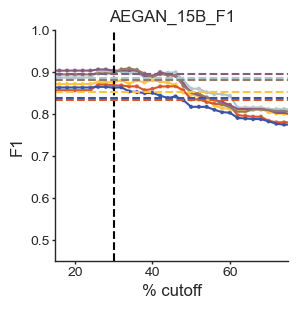

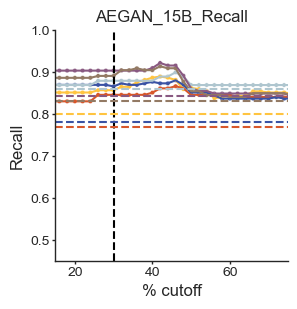

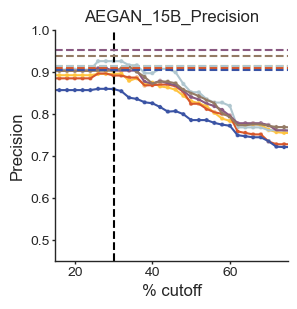

In [102]:
make_figure(df, x='% cutoff', y='F1', hue='Dataset', filename='AEGAN_15B_F1.svg')
make_figure(df, x='% cutoff', y='Recall', hue='Dataset', filename='AEGAN_15B_Recall.svg')
make_figure(df, x='% cutoff', y='Precision', hue='Dataset', filename='AEGAN_15B_Precision.svg')

In [103]:
df[df['% cutoff'] == 30]

,Dataset,% cutoff,F1,Precision,Recall,Support,% fully correct,% with difference,% missing,Mean correct
90,NN,30,0.867725,0.891304,0.845361,194,0.750000,0.212963,0.037037,0.829475
91,HA_superfamily,30,0.862319,0.859206,0.865455,275,0.736842,0.230263,0.032895,0.816557
92,PC,30,0.901554,0.925532,0.878788,99,0.818182,0.163636,0.018182,0.860606
93,EF_fold,30,0.903030,0.903030,0.903030,165,0.774194,0.204301,0.021505,0.848566
94,EF_superfamily,30,0.896552,0.902778,0.890411,219,0.788618,0.186992,0.024390,0.853659
95,EF_family,30,0.875346,0.895184,0.856369,369,0.775510,0.198980,0.025510,0.851616


In [104]:
df[df['% cutoff'] == 0]

,Dataset,% cutoff,F1,Precision,Recall,Support,% fully correct,% with difference,% missing,Mean correct
0,NN,0,0.856383,0.884615,0.829897,194,0.750000,0.222222,0.027778,0.824846
1,HA_superfamily,0,0.862816,0.856631,0.869091,275,0.743421,0.236842,0.019737,0.823136
2,PC,0,0.886598,0.905263,0.868687,99,0.800000,0.200000,0.000000,0.851515
3,EF_fold,0,0.903030,0.903030,0.903030,165,0.784946,0.204301,0.010753,0.853943
4,EF_superfamily,0,0.894009,0.902326,0.885845,219,0.788618,0.186992,0.024390,0.852304
5,EF_family,0,0.871012,0.892045,0.850949,369,0.770408,0.204082,0.025510,0.847364
